<a href="https://colab.research.google.com/github/animesh-rai/PII-Detection-Using-state-of-the-art-model/blob/main/pii_detection_using_facebook_bart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
#Import packages
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from sklearn.metrics import classification_report, precision_recall_fscore_support
from collections import Counter
import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gc
import re
import random
from itertools import chain

#import wandb
# Initialize wandb
#wandb.init(project="pii-detection")

#Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42
set_seed(seed_value)

import time
# Capture the start time
start_time = time.time()
print("Start Time: ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

Start Time:  2024-11-15 08:54:51


In [3]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Data
Load the training data from the provided JSON file and create a Hugging Face Dataset object. The data is split into training and evaluation sets.

In [5]:
from transformers import AutoModel, BartTokenizerFast, AutoModelForSeq2SeqLM, BartForConditionalGeneration
# Load dataset
dataset = datasets.load_dataset('json', data_files='/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/train.json')
# Convert to DataFrame and preprocess
df = dataset['train'].to_pandas()
# Take the first 1500 rows
df = df.iloc[:1500]
all_labels = [label for sublist in df['labels'] for label in sublist]
unique_labels = list(set(all_labels))
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}
all_labels = list(label2id.keys())  # Get all unique labels from mapping
num_labels = len(all_labels)  # Update the num_labels


# Tokenizer and Model
tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-base", add_prefix_space=True)
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base",from_flax=True, num_labels=num_labels, id2label=id2label, label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Split Dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
dataset_dict = datasets.DatasetDict({'train': train_dataset, 'test': test_dataset})

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

flax_model.msgpack:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_flax_pytorch_utils.py:459: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  pt_model_dict[flax_key] = torch.from_numpy(flax_tensor)
Some weights of the Flax model were not used when initializing the PyTorch model BartForConditionalGeneration: ['shared.weight', 'encoder.embed_positions.weight', 'encoder.layers.0.self_attn.k_proj.weight', 'encoder.layers.0.self_attn.v_proj.weight', 'encoder.layers.0.self_attn.q_proj.weight', 'encoder.layers.0.self_attn.out_proj.weight', 'encoder.layers.0.self_attn_layer_norm.weight', 'encoder.layers.0.fc1.weight', 'encoder.layers.0.

cuda


### Data Exploration

The dataset has four columns, 'document', 'tokens', 'labels', and 'trailing_whitespace'. Pandas can be used to visualize the dataset and get a better understanding of the structure.

In [6]:
print('Dataset length', len(dataset))
dataset

Dataset length 1


DatasetDict({
    train: Dataset({
        features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'],
        num_rows: 6807
    })
})

In [7]:
df = pd.read_json('/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/train.json')
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


The pandas data frame produces a better visualization of the structure of the JSON file. Each row represents an essay written by a student. There are 6807 Rows in the data frame, each row representing a student essay. The column 'full text' contains the full essay. The 'Tokens' column contains the text separated by tokens. The trailing white space column is a list of placeholders indicating if a token contains a trailing white space. Finally, the labels column represents a label for each token. Each token is as one of our desired categories of PII, or 'O' if the token does not belong to PII a category.

We can view the first full essay as an example. A function 'format_text' is used to make the document more readable for humans.

In [8]:
def format_text(text):
    # Add paragraph breaks
    formatted_text = text.replace('\n\n', '\n\n<p>\n\n')

    # Add bullet points to list items
    formatted_text = re.sub(r'•\s', '\n- ', formatted_text)

    # Handle remaining single newlines
    formatted_text = re.sub(r'(?<!\n)\n(?!\n)', ' ', formatted_text)

    # Remove leading and trailing spaces
    formatted_text = re.sub(r'\s+\n', '\n', formatted_text)
    formatted_text = re.sub(r'\n\s+', '\n', formatted_text)

    return formatted_text

# Example usage
raw_text = df['full_text'][0]

print(format_text(raw_text))

Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla
<p>
Challenge & selection
<p>
The tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.
<p>
What exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1
<p>
This tool has many advantages:
<p>
-  It is accessible to all and does not require significant material investment and can be done  quickly
<p>
-  It is scalable
<p>
-  It allows categorization and linking of information
<p>
-  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas
<p>
-  It is suitable for all people and is easy to learn
<p>
-  It is fun and encourages exchanges
<p>
-  It 

#### Distribution of the unique labels.

In [9]:
# Count the frequency of each label in the 'train' dataset
label_freq = Counter(chain(*train_dataset['labels']))

# Display the frequency of each label
for label, freq in label_freq.items():
    print(f"Label: {label}, Frequency: {freq}")

Label: B-NAME_STUDENT, Frequency: 827
Label: I-NAME_STUDENT, Frequency: 685
Label: O, Frequency: 916787
Label: B-EMAIL, Frequency: 22
Label: B-URL_PERSONAL, Frequency: 60
Label: B-ID_NUM, Frequency: 29
Label: B-USERNAME, Frequency: 6
Label: B-STREET_ADDRESS, Frequency: 1
Label: I-STREET_ADDRESS, Frequency: 10
Label: B-PHONE_NUM, Frequency: 3
Label: I-PHONE_NUM, Frequency: 6
Label: I-URL_PERSONAL, Frequency: 1


The data set is heavily distributed with tokens that do not belong to a PII category (ie 'O' labels). We will use a focal loss and class weights with our model to help with this class imbalance. This will help ensure our model does not simply predict all 'O's' given the large distribution of those labels.



#### Tokenization and Alignment of Labels
Explanations of the unique labels in the data set are below. These are the desired PII categories we seek to identify in the student essays. Note the tokens are split using a 'piece wise' tokenizer format.

##### Explanation of Labels:

B-EMAIL: Beginning of an email address.
B-ID_NUM: Beginning of an identification number.
B-NAME_STUDENT: Beginning of a student's name.
B-PHONE_NUM: Beginning of a phone number.
B-STREET_ADDRESS: Beginning of a street address.
B-URL_PERSONAL: Beginning of a personal URL.
B-USERNAME: Beginning of a username.
I-ID_NUM: Inside an identification number.
I-NAME_STUDENT: Inside a student's name.
I-PHONE_NUM: Inside a phone number.
I-STREET_ADDRESS: Inside a street address.
I-URL_PERSONAL: Inside a personal URL.
O: Outside of any named entity.

DeBERTa (Decoding-enhanced BERT with disentangled attention) improves the BERT and RoBERTa models using two novel techniques. The first is the disentangled attention mechanism, where each word is represented using two vectors that encode its content and position, respectively, and the attention weights among words are computed using disentangled matrices on their contents and relative positions. Second, an enhanced mask decoder is used to replace the output softmax layer to predict the masked tokens for model pretraining. We show that these two techniques significantly improve the efficiency of model pre-training and performance of downstream tasks.

##### Piecewise Tokenization:

The DeBERTa model uses a 'piecewise' tokenizer. This type of tokenizer breaks down text into smaller subword units, which is useful for handling rare words and morphological variations. It ensures that even if a word is not in the vocabulary, the tokenizer can still represent it using smaller known subword units.

##### Tokenization Process:

Token Splitting: The text is split into tokens based on whitespace and punctuation.

Subword Tokenization: Each token is further split into subwords. For example, the word "unhappiness" might be split into "un", "happi", and "ness".

Label Alignment: Labels are aligned with the subword tokens. If a token is split into multiple subwords, the label for the original token is assigned to the first subword, and a special label (typically -100) is assigned to the subsequent subwords.
Here's an example of how a token and its label might be split and aligned:

Original token: "unhappiness" (Label: B-EMOTION) Subword tokens: ["un", "happi", "ness"] Aligned labels: [B-EMOTION, -100, -100]

The alignment ensures that the model learns to identify entities correctly even when tokens are split into subwords.

</font>

A function to tokenize the input data and align the labels with the tokenized inputs s also defined. his function handles the trailing whitespace correctly. The map function, which is included in the datasets library, is used to map the function to all of the documents in the data set. This will create the tokenized dataset required for the Hugging Face Deberta model.


In [10]:
#Define function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=512
        #,return_offsets_mapping=True
    )

    batch_original_tokens = []
    batch_tokenized_tokens = []
    batch_label_ids = []
    batch_input_ids = []
    batch_attention_masks = []
    batch_token_type_ids = []

    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        original_tokens = examples["tokens"][i]
        tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][i])

        previous_word_idx = None
        label_ids = []
        original_token_list = []
        tokenized_token_list = []
        input_id_list = []
        attention_mask_list = []
        token_type_id_list = []

        for j, word_idx in enumerate(word_ids):
            if word_idx is None:
                label_ids.append(-100)
                current_original_token = ''  # Special token
            elif word_idx == previous_word_idx:
                label_ids.append(-100)
                current_original_token = ''  # Subword token
            else:
                label_ids.append(label2id[label[word_idx]])
                current_original_token = original_tokens[word_idx]

            original_token_list.append(current_original_token)
            tokenized_token_list.append(tokenized_tokens[j])
            input_id_list.append(tokenized_inputs["input_ids"][i][j])
            attention_mask_list.append(tokenized_inputs["attention_mask"][i][j])
            if "token_type_ids" in tokenized_inputs:
                token_type_id_list.append(tokenized_inputs["token_type_ids"][i][j])
            else:
                token_type_id_list.append(0)
            previous_word_idx = word_idx  # Update for the next iteration

        batch_original_tokens.append(original_token_list)
        batch_tokenized_tokens.append(tokenized_token_list)
        batch_label_ids.append(label_ids)
        batch_input_ids.append(input_id_list)
        batch_attention_masks.append(attention_mask_list)
        batch_token_type_ids.append(token_type_id_list)

    # Include BERT-required columns
    return {
        "original_tokens": batch_original_tokens,
        "tokenized_tokens": batch_tokenized_tokens,
        "labels": batch_label_ids,
        "input_ids": batch_input_ids,
        "attention_mask": batch_attention_masks,
        "token_type_ids": batch_token_type_ids
    }

# Tokenize
tokenized_datasets = dataset_dict.map(tokenize_and_align_labels, batched=True)

gc.collect()

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

95

It is important to ensure the tokenizer works correctly. The function below displays a comparison of the original tokens to the processed tokens.

In [11]:
import datasets

# Function to print the first few elements of each relevant column
def print_comparison(dataset, num_elements=20):
    first_document = dataset[0]
    original_tokens = first_document['original_tokens'][:num_elements]
    tokenized_tokens = first_document['tokenized_tokens'][:num_elements]
    labels = first_document['labels'][:num_elements]
    input_ids = first_document['input_ids'][:num_elements]
    attention_mask = first_document['attention_mask'][:num_elements]
    token_type_ids = first_document['token_type_ids'][:num_elements]

    # Print the columns in a readable format
    for i in range(num_elements):
        print(f"Original Token: {original_tokens[i]:<15} | "
              f"Tokenized Token: {tokenized_tokens[i]:<20} | "
              f"Label: {labels[i]:<5} | "
              f"Input ID: {input_ids[i]:<10} | "
              f"Attention Mask: {attention_mask[i]:<5} | "
              f"Token Type ID: {token_type_ids[i]}")

# Example usage with the train dataset
print("Comparison of first 20 elements for the first document in the train dataset:")
print_comparison(tokenized_datasets['train'], num_elements=20)

Comparison of first 20 elements for the first document in the train dataset:
Original Token:                 | Tokenized Token: <s>                  | Label: -100  | Input ID: 0          | Attention Mask: 1     | Token Type ID: 0
Original Token: Mauro           | Tokenized Token: ĠMau                 | Label: 3     | Input ID: 14147      | Attention Mask: 1     | Token Type ID: 0
Original Token:                 | Tokenized Token: ro                   | Label: -100  | Input ID: 1001       | Attention Mask: 1     | Token Type ID: 0
Original Token: Zizza           | Tokenized Token: ĠZ                   | Label: 7     | Input ID: 525        | Attention Mask: 1     | Token Type ID: 0
Original Token:                 | Tokenized Token: izza                 | Label: -100  | Input ID: 35280      | Attention Mask: 1     | Token Type ID: 0
Original Token: ,               | Tokenized Token: Ġ,                   | Label: 8     | Input ID: 2156       | Attention Mask: 1     | Token Type ID: 0
Origi

The tokenizer appears to have processed the original tokens correctly. We can remove the unnecessary column from the tokenized data set and only keep the columns required for training.

In [12]:
# List of columns to keep
columns_to_keep = ['labels', 'input_ids', 'attention_mask', 'token_type_ids']

# Function to remove unnecessary columns
def remove_unnecessary_columns(dataset, columns_to_keep):
    return dataset.remove_columns([column for column in dataset.column_names if column not in columns_to_keep])

# Apply the function to both train and test datasets
tokenized_datasets['train'] = remove_unnecessary_columns(tokenized_datasets['train'], columns_to_keep)
tokenized_datasets['test'] = remove_unnecessary_columns(tokenized_datasets['test'], columns_to_keep)

##### facebook bart Model Training
Recall the data set is imbalanced, with the vast majority of labels belonging to a non-PII category 'O.' Class weights with a weighted loss function will be used to help with this imbalance. This means the model will put more focus on the minority classes and will put less weight on the majority classes when training. Also, a custom compute metrics function with a classification report is defined for evaluation.

In [13]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

Creating a custom callback to track the loss at each epoch's end and log it for later plotting

In [33]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Custom callback to log loss at the end of each epoch
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Check if log_history has entries
        if state.log_history and 'loss' in state.log_history[-1]:
            # Store the loss of the current epoch
            self.epoch_losses.append(state.log_history[-1]['loss'])
        else:
            print("Warning: No loss logged for this epoch.")

# Initialize the callback
loss_logger = LossLoggerCallback()

In [34]:
class BartForTokenClassification(nn.Module):
    def __init__(self, model, num_labels):
        super(BartForTokenClassification, self).__init__()
        self.model = model.model  # Use the underlying BART model
        self.classifier = nn.Linear(768, num_labels)  # Add custom classification head

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden_states = outputs.last_hidden_state
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, num_labels)[active_loss]
            active_labels = labels.view(-1)[active_loss]
            loss = loss_fct(active_logits, active_labels)

        return {"loss": loss, "logits": logits}

    def save_pretrained(self, save_directory):
      # Save the underlying BART model and the classifier
      self.model.save_pretrained(save_directory)  # Saves the BART model's weights
      torch.save(self.classifier.state_dict(), f"{save_directory}/bart_classifier.pt")  # Save classifier separately

    @classmethod
    def from_pretrained(cls, save_directory, num_labels):
        # Load the underlying BART model and the custom classifier
        base_model = BartForConditionalGeneration.from_pretrained(save_directory)
        model = cls(base_model, num_labels)
        classifier_state_dict = torch.load(f"{save_directory}/bart_classifier.pt")
        model.classifier.load_state_dict(classifier_state_dict)
        return model

    def get_device(self):
        # Retrieve the device of the model's parameters
        return next(self.parameters()).device

# Initialize the custom model
num_labels = 13  # Replace with the actual number of PII classes
base_model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
model = BartForTokenClassification(base_model, num_labels)

# Define data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Define Focal Loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)

    def forward(self, inputs, targets):
        if self.alpha is not None:
            self.alpha = self.alpha.to(inputs.device)  # Ensure alpha is on the correct device
        BCE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-BCE_loss)
        F_loss = ((1 - pt) ** self.gamma) * BCE_loss
        return F_loss.mean()

# Initialize Focal Loss with class weights
class_weights = torch.ones(num_labels).to("cuda")  # Replace with actual class weights if available
loss_fn = FocalLoss(gamma=2, alpha=class_weights)

# Define custom compute metrics function
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[label] for label in doc if label != -100] for doc in labels]
    true_predictions = [
        [id2label[pred] for pred, label in zip(doc, labels[i]) if label != -100]
        for i, doc in enumerate(predictions)
    ]

    true_labels_flat = [item for sublist in true_labels for item in sublist]
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]

    results = precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='weighted')
    class_report = classification_report(
        true_labels_flat, true_predictions_flat, labels=all_labels, zero_division=0
    )

    print("Classification Report:\n", class_report)
    return {
        "precision": results[0],
        "recall": results[1],
        "f1": results[2],
        "accuracy": (results[2] * results[1])
    }

# Custom Trainer with custom loss function
class CustomTrainer(Trainer):
    def __init__(self, loss_fn, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        device = model.get_device()
        inputs = {key: value.to(device) for key, value in inputs.items()}  # Ensure inputs are on the same device
        labels = inputs.pop("labels").to(device)  # Ensure labels are on the same device

        outputs = model(**inputs)
        logits = outputs["logits"]
        loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
        # Log the loss explicitly
        self.log({"loss": loss.item()})
        return (loss, outputs) if return_outputs else loss

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=10,  # Log every 10 steps
    save_strategy="no",  # Disable default checkpoint saving
    report_to='none'
)

# Initialize Custom Trainer
trainer = CustomTrainer(
    loss_fn=loss_fn,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_logger]  # the loss logger callback
)


<ipython-input-34-f142fb4e1c49>:101: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [35]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.000038,0.001585,0.998779,0.999057,0.998909,0.997967
2,0.000040,0.000631,0.999453,0.999465,0.999454,0.998920
3,0.000012,0.000552,0.999510,0.999488,0.999493,0.998981
4,0.000014,0.000724,0.999505,0.999451,0.999466,0.998917
5,0.000006,0.000615,0.999514,0.999480,0.999487,0.998968


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

         B-EMAIL       0.00      0.00      0.00         5
      B-USERNAME       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.80      0.83      0.81       153
        B-ID_NUM       0.00      0.00      0.00        23
  I-URL_PERSONAL       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.00      0.00      0.00        10
  I-NAME_STUDENT       0.81      1.00      0.89       119
               O       1.00      1.00      1.00    134379
     B-PHONE_NUM       0.00      0.00      0.00         2
     I-PHONE_NUM       0.00      0.00      0.00         4
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    134695
       macro avg       0.22      0.24      0.23    134695
    weighted avg       1.00      1.00      1.00    134695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

         B-EMAIL       1.00      1.00      1.00         5
      B-USERNAME       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.87      0.88      0.87       153
        B-ID_NUM       0.76      0.83      0.79        23
  I-URL_PERSONAL       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.59      1.00      0.74        10
  I-NAME_STUDENT       0.91      0.97      0.94       119
               O       1.00      1.00      1.00    134379
     B-PHONE_NUM       0.00      0.00      0.00         2
     I-PHONE_NUM       0.00      0.00      0.00         4
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    134695
       macro avg       0.43      0.47      0.45    134695
    weighted avg       1.00      1.00      1.00    134695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

         B-EMAIL       1.00      1.00      1.00         5
      B-USERNAME       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.86      0.87      0.87       153
        B-ID_NUM       0.95      0.78      0.86        23
  I-URL_PERSONAL       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.62      0.80      0.70        10
  I-NAME_STUDENT       0.92      1.00      0.96       119
               O       1.00      1.00      1.00    134379
     B-PHONE_NUM       0.00      0.00      0.00         2
     I-PHONE_NUM       1.00      0.50      0.67         4
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    134695
       macro avg       0.53      0.50      0.50    134695
    weighted avg       1.00      1.00      1.00    134695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

         B-EMAIL       1.00      1.00      1.00         5
      B-USERNAME       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.81      0.92      0.86       153
        B-ID_NUM       0.88      0.91      0.89        23
  I-URL_PERSONAL       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.59      1.00      0.74        10
  I-NAME_STUDENT       0.89      1.00      0.94       119
               O       1.00      1.00      1.00    134379
     B-PHONE_NUM       0.00      0.00      0.00         2
     I-PHONE_NUM       0.67      1.00      0.80         4
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    134695
       macro avg       0.49      0.57      0.52    134695
    weighted avg       1.00      1.00      1.00    134695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

         B-EMAIL       1.00      1.00      1.00         5
      B-USERNAME       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.82      0.92      0.87       153
        B-ID_NUM       0.95      0.78      0.86        23
  I-URL_PERSONAL       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.62      1.00      0.77        10
  I-NAME_STUDENT       0.90      1.00      0.95       119
               O       1.00      1.00      1.00    134379
     B-PHONE_NUM       0.00      0.00      0.00         2
     I-PHONE_NUM       0.80      1.00      0.89         4
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    134695
       macro avg       0.51      0.56      0.53    134695
    weighted avg       1.00      1.00      1.00    134695



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

         B-EMAIL       1.00      1.00      1.00         5
      B-USERNAME       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.82      0.92      0.87       153
        B-ID_NUM       0.95      0.78      0.86        23
  I-URL_PERSONAL       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.62      1.00      0.77        10
  I-NAME_STUDENT       0.90      1.00      0.95       119
               O       1.00      1.00      1.00    134379
     B-PHONE_NUM       0.00      0.00      0.00         2
     I-PHONE_NUM       0.80      1.00      0.89         4
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    134695
       macro avg       0.51      0.56      0.53    134695
    weighted avg       1.00      1.00      1.00    134695

{'eval_loss': 0.0006152931018732488, 'eval_pr

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:388: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(


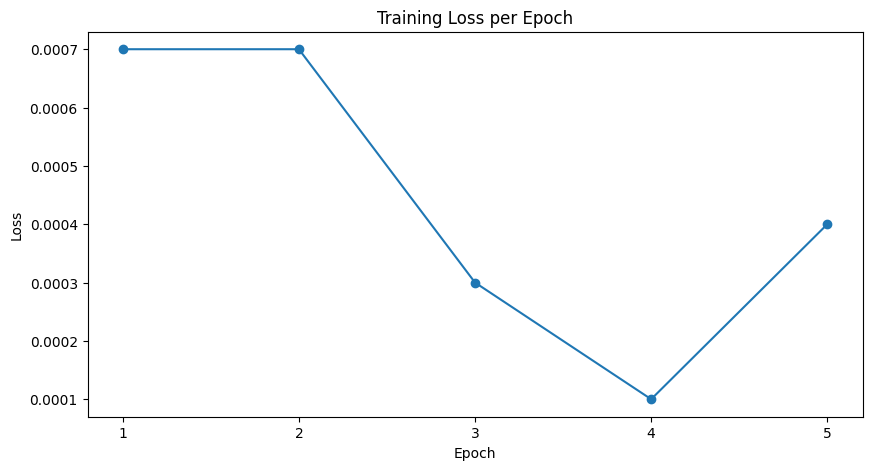

In [36]:
save_directory = "./bart_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

# Plot the epoch losses after training
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_logger.epoch_losses) + 1), loss_logger.epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.xticks(range(1, len(loss_logger.epoch_losses) + 1))  # Set x-axis ticks to match epoch numbers
plt.show()

In [37]:
# Load test dataset
test_dataset = datasets.load_dataset('json', data_files='/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/test.json')['train']

def tokenize_test_set(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=512,
        return_offsets_mapping=True
    )

    batch_original_tokens = []
    batch_tokenized_tokens = []
    batch_input_ids = []
    batch_attention_masks = []
    batch_token_type_ids = []
    batch_offset_mappings = []  # New line to store offset mappings

    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        original_tokens = examples["tokens"][i]
        tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][i])

        original_token_list = []
        tokenized_token_list = []
        input_id_list = []
        attention_mask_list = []
        token_type_id_list = []

        for j, word_idx in enumerate(word_ids):
            current_original_token = '' if word_idx is None else original_tokens[word_idx]

            original_token_list.append(current_original_token)
            tokenized_token_list.append(tokenized_tokens[j])
            input_id_list.append(tokenized_inputs["input_ids"][i][j])
            attention_mask_list.append(tokenized_inputs["attention_mask"][i][j])
            if "token_type_ids" in tokenized_inputs:
                token_type_id_list.append(tokenized_inputs["token_type_ids"][i][j])
            else:
                token_type_id_list.append(0)

        batch_original_tokens.append(original_token_list)
        batch_tokenized_tokens.append(tokenized_token_list)
        batch_input_ids.append(input_id_list)
        batch_attention_masks.append(attention_mask_list)
        batch_token_type_ids.append(token_type_id_list)
        # Append offset_mapping for the current sample
        batch_offset_mappings.append(tokenized_inputs['offset_mapping'][i])

    return {
        "original_tokens": batch_original_tokens,
        "tokenized_tokens": batch_tokenized_tokens,
        "input_ids": batch_input_ids,
        "attention_mask": batch_attention_masks,
        "token_type_ids": batch_token_type_ids,
        "offset_mapping": batch_offset_mappings,
    }

test_dataset = test_dataset.map(tokenize_test_set, batched=True)

# List of columns to keep
columns_to_keep = ['document', 'input_ids', 'attention_mask', 'token_type_ids']
test_dataset = test_dataset.remove_columns([col for col in test_dataset.column_names if col not in columns_to_keep])
# Define the confidence threshold
confidence_threshold = 0.95

# Predict on test dataset
test_predictions = trainer.predict(test_dataset)
pred_probs = test_predictions.predictions
preds = np.argmax(pred_probs, axis=2)
max_probs = np.max(pred_probs, axis=2)

# Create submission file
submission = []

for i, doc in enumerate(pred_probs):
    word_ids = test_dataset[i]['input_ids']
    for j, word_id in enumerate(word_ids):
        if word_id != tokenizer.pad_token_id:
            row_id = len(submission)
            document_id = test_dataset[i]['document']
            token_id = j
            pred_label = id2label[preds[i][j]]
            if pred_label != 'O' and max_probs[i][j] >= confidence_threshold:  # Exclude outside labels and apply threshold
                submission.append([row_id, document_id, token_id, pred_label])

submission_df = pd.DataFrame(submission, columns=["row_id", "document", "token", "label"])

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
print(submission_df)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

TypeError: Unsupported types (<class 'NoneType'>) passed to `_pad_across_processes`. Only nested list/tuple/dicts of objects that are valid for `is_torch_tensor` should be passed.